In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
import cv2 as cv
from tqdm import tqdm
import string
from sklearn.model_selection import train_test_split
from tensorflow.keras.backend import ctc_decode, get_value
from utils import preprocess_image


In [2]:
PATH = '../dataset/Date-Synth/images/'

In [3]:
ANNOTATIONS_PATH = '../dataset/Date-Synth/annotations.json'

with open(ANNOTATIONS_PATH, 'r') as file:
    data = json.load(file)

def get_y_from_json(file: str) -> str:
    return " ".join(annotation['transcription'] for annotation in data[file]['ann'])

In [4]:
get_y_from_json('00001.jpg')

'10 10 2016'

Loading images: 100%|██████████| 20000/20000 [18:04<00:00, 18.45it/s]


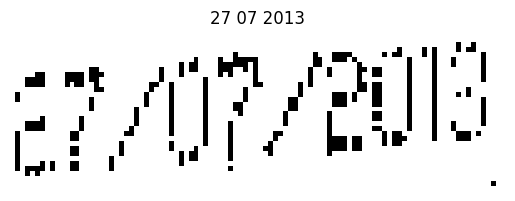

In [5]:
# Load dataset

X = []
Y = []

target_size = (32, 100)

n = 20000

for idx, file in enumerate(tqdm(os.listdir(PATH)[:n], total=n, desc="Loading images")):

    file_path = os.path.join(PATH, file)

    image = tf.keras.preprocessing.image.load_img(file_path, color_mode='rgb', target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    
    image = preprocess_image(image, resize= False)

    label = get_y_from_json(file)

    if label != " ":
        X.append(image)
        Y.append(label)

X = np.array(X)
Y = np.array(Y)
    
plt.imshow(X[100], cmap='gray')
plt.title(Y[100])
plt.axis('off')
plt.show()

In [6]:
# Normalized

X = np.expand_dims(X, axis= -1)
X_normalized = X / 255.0

print(f'X shape: {X_normalized.shape} | Y shape: {Y.shape}')
print(f'X_normalized[0]: {X_normalized[0]} | Y[0]: {Y[0]}')

X shape: (20000, 32, 100, 1) | Y shape: (20000,)
X_normalized[0]: [[[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 ...

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]] | Y[0]: 21 09 2020


In [7]:
# Encode

char_list = string.ascii_letters + string.digits + ' ' # Digits because only for expiration date

index_to_char = {idx: character for idx, character in enumerate(char_list)}

def encode_label(label: str) -> list:
    
    encoded = []

    for char in label:
        try:
            encoded.append(char_list.index(char))
        except:
            print(f'Not found in char_list: {char}')

    return encoded

def decode_label(encoded) -> list:
        
    decoded = []

    for char_idx in encoded:
        
        if int(char_idx) != -1 and int(char_idx) != len(char_list): # -1 -> _ in CTC and len(char_list) -> pad
            
            decoded.append(index_to_char[char_idx])
                
    return decoded
    
Y_encoded = [encode_label(label) for label in Y]

print(''.join([index_to_char[encode_idx] for encode_idx in Y_encoded[0]]))

21 09 2020


In [8]:
# Max sequence len

max_len = max(len(seq) for seq in Y_encoded)

max_len

11

In [9]:
# Pad sequence

Y_padded = tf.keras.preprocessing.sequence.pad_sequences(Y_encoded, maxlen= max_len, padding='post', value=len(char_list))

In [10]:
# Split

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y_padded, test_size= 0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size= 0.5, random_state=42)

In [11]:
# Define input shape


input_shape = X[0].shape

input_shape

(32, 100, 1)

In [12]:
class MapToSequenceLayer(tf.keras.layers.Layer):

    def __call__(self, inputs):

        # Input = (batch_size, height, width, channels) => Feature Map

        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]
        channels = tf.shape(inputs)[3]


        # Output = (batch_size, width, height * channels) => sequence per columns

        outputs = tf.reshape(inputs, (batch_size, width, height * channels))

        return outputs

In [13]:
class CTCLoss(tf.keras.losses.Loss):

    def __init__(self, name: str = 'CTCLoss') -> None:

        super(CTCLoss, self).__init__()
        self.name = name
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def __call__(self, y_true: tf.Tensor, y_pred: tf.Tensor, sample_weight= None) -> tf.Tensor:

        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)

        return loss


In [14]:
# Model

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(512, kernel_size=(2, 2), padding='valid', activation='relu'),
    MapToSequenceLayer(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Dense(len(char_list) + 1, activation='softmax')
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 100, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 50, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 50, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 25, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 25, 256)        295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 25, 256)        5

In [15]:
print(Y_train[0])
print(len(char_list) + 1)
print(model.output_shape)


[54 52 53 57 62 40  2 19 62 54 58]
64
(None, 24, 64)


In [16]:
# Compile model

BATCH_SIZE = 16
EPOCHS = 100

model.compile(optimizer= tf.keras.optimizers.Adadelta(), loss= CTCLoss())

model.fit(X_train, Y_train, 
          validation_data= (X_val, Y_val), 
          batch_size= BATCH_SIZE, 
          epochs= EPOCHS)

Epoch 1/100
 115/1000 [==>...........................] - ETA: 21:00 - loss: 55.4197

KeyboardInterrupt: 

In [ ]:
Y_pred = model.predict(X_test)

ctc_input_length = np.ones(Y_pred.shape[0]) * Y_pred.shape[1]

print(ctc_input_length.shape)

output = get_value(ctc_decode(Y_pred, input_length= ctc_input_length, greedy= True)[0][0])

37/37 [==============================] - 2s 31ms/step
(1184,)


In [ ]:
output[0]

array([54, 62, 53, 58, 62, 53, 59, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1], dtype=int64)

In [ ]:
Y_test[0]

array([53, 60, 62, 35, 46, 39, 62, 53, 59, 63, 63])

In [ ]:
def character_accuracy(pred_text, truth_text):
    correct_chars = sum([1 for p, t in zip(pred_text, truth_text) if p == t])
    return correct_chars / len(truth_text) if len(truth_text) > 0 else 0.0

def exact_match_accuracy(pred_text, truth_text):
    return 1 if pred_text == truth_text else 0

correct_char_count = 0
exact_match_count = 0
total_samples = Y_pred.shape[0]  # Checking the first 5 samples

for idx in range(total_samples):
    pred_text = ''.join([char for char in decode_label(output[idx])])
    truth_text = ''.join([char for char in decode_label(Y_test[idx])])

    char_acc = character_accuracy(pred_text, truth_text)
    exact_acc = exact_match_accuracy(pred_text, truth_text)
    
    # print(f"Pred = {pred_text} | Truth: {truth_text}")
    # print(f"Character-level accuracy: {char_acc:.4f}")
    # print(f"Exact match accuracy: {exact_acc}")
    
    correct_char_count += char_acc
    exact_match_count += exact_acc

avg_char_accuracy = correct_char_count / total_samples
avg_exact_accuracy = exact_match_count / total_samples

print(f"Average character-level accuracy: {avg_char_accuracy:.4f}")
print(f"Average exact match accuracy: {avg_exact_accuracy}")


Average character-level accuracy: 0.3045
Average exact match accuracy: 0.0008445945945945946
